# How to create Figure 6


**Paper:** https://arxiv.org/pdf/2002.09301.pdf



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from difflikelihoods import odesolver
from difflikelihoods import linearised_odesolver as linsolver
from difflikelihoods import linearised_ode as linode
from difflikelihoods import statespace
from difflikelihoods import inverseproblem as ip
from difflikelihoods.optimisation import minimise_newton, minimise_gd, minimise_rs
from sampling_functions import *

At first we create the data, set the model parameters and the method parameters.

In [2]:
d_guiy = 9

def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __, __, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, d_guiy, 0)
    evalpts = np.array([h, 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100.])
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    noise = np.sqrt(ivpvar)*np.random.randn(len(evalpts) * d_guiy).reshape((len(evalpts), d_guiy))
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = means[evalidcs] + noise # this is 'wrong' noise
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata


## Optimisation experiments

We begin with the optimisation experiments. We begin by specifying the model and method parameters.

In [3]:
# Set Model Parameters
initial_value = np.ones([d_guiy])
initial_time, end_time = 0., 100.
ivpvar = 1e-5    # maybe change this later?
thetatrue = np.array([ 0.1,  0.01,  0.4,  0.01,  0.3, 0.01,  0.7,  0.01,  0.1,  0.2])
ivp = linode.GUiY(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/10000
h = (end_time - initial_time)/2000
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=d_guiy))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)

Next, we specify an initial value and compute the minisers for Newton, GD and RS as well as the respective root mean squared errors.

In [4]:
# Make a particle follow a trajectory through the parameter space
niter = 100
init_theta = 1.2 *  np.array([ 0.1,  0.0,  0.4,  0.0,  0.3, 0.0,  0.7,  0.0,  0.1,  0.2]) + np.random.rand(10)*0.01

traj_gd, obj_gd = minimise_gd(iplklhd.potenteval, iplklhd.gradeval, niter, init_theta, lrate=1e-7)
error_gd = np.sqrt(np.sum(np.abs(traj_gd - thetatrue)**2/(thetatrue + 1e-6)**2 ,axis=-1)) # + 1e-6 to avoid division by zero

traj_newton, obj_newton = minimise_newton(iplklhd.potenteval, iplklhd.gradeval, iplklhd.hesseval, niter, init_theta, lrate=1.)
error_newton = np.sqrt(np.sum(np.abs(traj_newton - thetatrue)**2/(thetatrue + 1e-6)**2 ,axis=-1))  # + 1e-6 to avoid division by zero

traj_rs, obj_rs = minimise_rs(iplklhd.potenteval, niter, init_theta, lrate=1e-3)
error_rs = np.sqrt(np.sum(np.abs(traj_rs - thetatrue)**2/(thetatrue + 1e-6)**2 ,axis=-1))

benchmark = np.average(np.sqrt(np.diag(iplklhd.ipvar)))
stdev = np.sqrt(ivpvar)


In [5]:
print("Init:", init_theta)
print("Newton guess:", traj_newton[-1], (np.abs((traj_newton[-1] - thetatrue[:]))/np.abs(thetatrue[:])))
print("Truth:", thetatrue)
print("GD guess:", traj_gd[-1])
print("RS guess:", traj_rs[-1])

print(traj_gd.shape, thetatrue.shape)


Init: [0.12187616 0.00715563 0.48012095 0.00460984 0.36763162 0.00758792
 0.84164428 0.00335841 0.1230438  0.24333977]
Newton guess: [0.10068542 0.01016288 0.40317268 0.01023765 0.29908384 0.00995523
 0.70390069 0.01014407 0.10066576 0.20115218] [0.00685422 0.01628754 0.00793171 0.02376472 0.00305386 0.00447693
 0.00557241 0.01440725 0.00665762 0.00576089]
Truth: [0.1  0.01 0.4  0.01 0.3  0.01 0.7  0.01 0.1  0.2 ]
GD guess: [0.11518807 0.0128596  0.47596948 0.01553598 0.3623884  0.01340726
 0.83734815 0.01235426 0.12276297 0.24143773]
RS guess: [0.11881704 0.01338955 0.48028513 0.01151782 0.36700545 0.01127943
 0.83837725 0.01182647 0.12080877 0.24059746]
(100, 10) (10,)


Finally, we can visualise the results using both the log-likelihood values and the error in the parameter space as metrics.

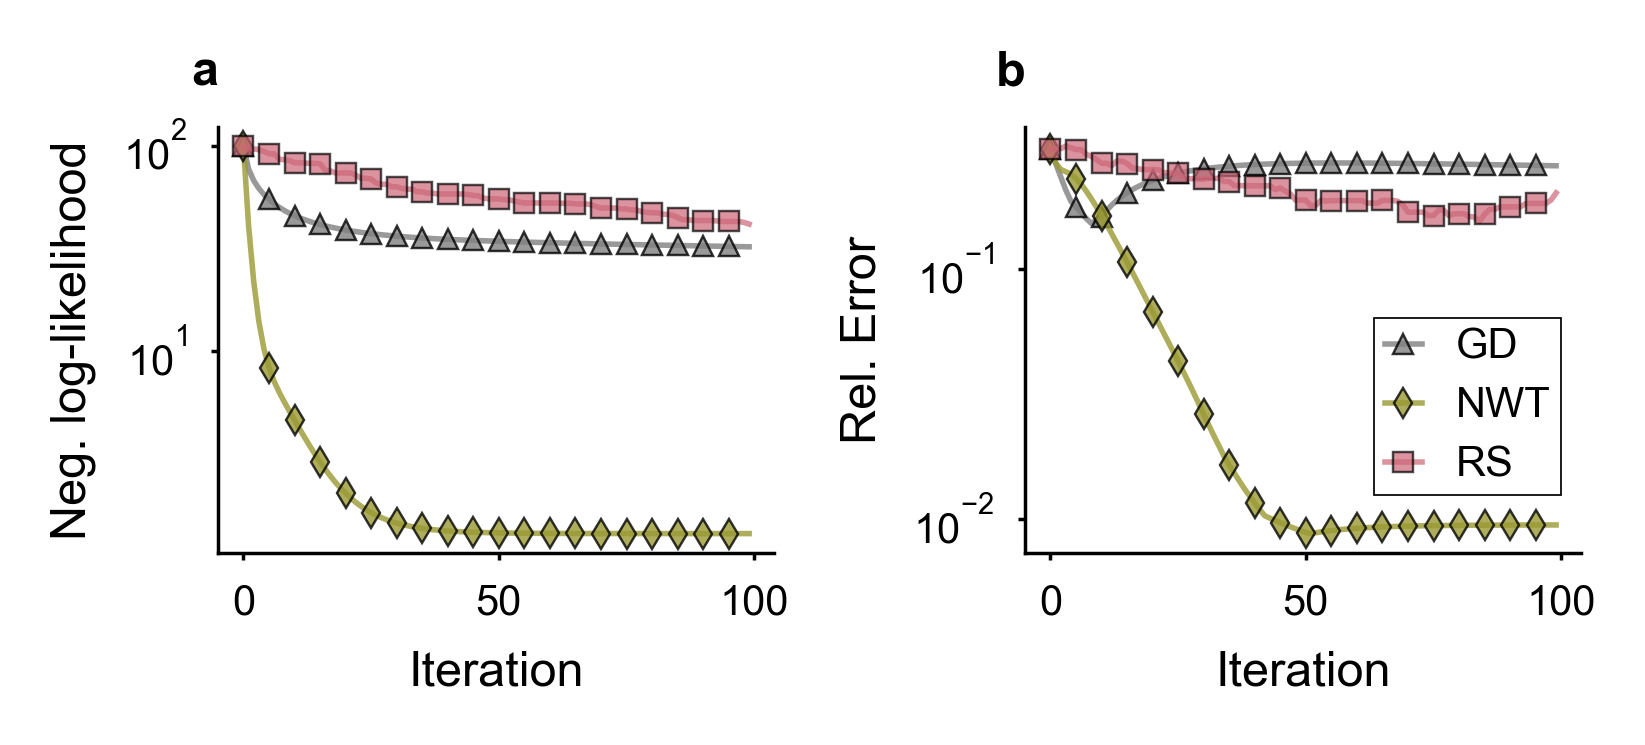

In [6]:
plt.style.use("./icmlstyle.mplstyle")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


ax1.set_xlabel("Iteration")
ax1.set_ylabel("Neg. log-likelihood")
mark_every = 5
ax1.semilogy((obj_gd), markevery=mark_every, color="gray", ls="-", marker="^", label="GD", alpha=0.8)
ax1.semilogy((obj_newton), markevery=mark_every, color="#999933", ls="-", marker="d", label="NWT", alpha=0.8)
ax1.semilogy((obj_rs), markevery=mark_every, color="#cc6677",   ls="-", marker="s", label="RS", alpha=0.7)

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Rel. Error")
ax2.semilogy((np.abs((traj_gd - thetatrue[np.newaxis, :]))/np.abs(thetatrue[np.newaxis, :])).mean(axis=1),  markevery=mark_every, color="gray", ls="-", marker="^", label="GD", alpha=0.8)
ax2.semilogy((np.abs((traj_newton - thetatrue[np.newaxis, :]))/np.abs(thetatrue[np.newaxis, :])).mean(axis=1), markevery=mark_every, color="#999933", ls="-", marker="d", label="NWT", alpha=0.8)
ax2.semilogy((np.abs((traj_rs - thetatrue[np.newaxis, :]))/np.abs(thetatrue[np.newaxis, :])).mean(axis=1), markevery=mark_every, color="#cc6677",  ls="-", marker="s", label="RS", alpha=0.7)


ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.6))
ax1.minorticks_off()
ax2.minorticks_off()
ax1.set_title("a", loc="left", fontweight='bold', ha='right')
ax2.set_title("b", loc="left", fontweight='bold', ha='right')

plt.tight_layout()
plt.savefig("./figures/figure6_optim_left.pdf")

plt.show()

## Sampling Experiments

Next, we repeat the experiments with the sampling algorithms. We start by specifying the model and method parameters.

In [7]:
def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __, __, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, d_guiy, 0)
    evalpts = np.array([h, 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100.])
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    noise = np.sqrt(ivpvar)*np.random.randn(len(evalpts) * d_guiy).reshape((len(evalpts), d_guiy))
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = means[evalidcs] + noise # this is 'wrong' noise
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata

In [10]:

# Set Model Parameters
initial_value = np.ones([d_guiy])
initial_time, end_time = 0., 100.
ivpvar = 1e-5    # maybe change this later?
thetatrue = np.array([ 0.1,  0.01,  0.4,  0.01,  0.3, 0.01,  0.7,  0.01,  0.1,  0.2])
ivp = linode.GUiY(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/10000
h = (end_time - initial_time)/2000
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=d_guiy))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)


Next, we sample from the posteriors with Langevin MCMC, Hamiltonian MC and random walk Metropolis-Hastings.

In [11]:
# Make a particle follow a trajectory through the parameter space
niter = 250
init_theta = 1.2 *  np.array([ 0.1,  0.0,  0.4,  0.0,  0.3, 0.0,  0.7,  0.0,  0.1,  0.2]) + np.random.rand(10)*0.01

samples_lang, probs_lang = langevin(niter, iplklhd, init_theta, stepsize=1., ninits=30)
samples_ham, probs_ham = hamiltonian(niter, iplklhd, init_theta, stepsize=.4, nsteps=4, ninits=30)
samples_rw, probs_rw = randomwalk(niter, iplklhd, init_theta, stepsize=.00003, ninits=30)


In [12]:
print("pHam mode:", samples_ham[np.argmin(probs_ham)])
print("pLang mode:", samples_lang[np.argmin(probs_lang)])
print("RW mode:", samples_rw[np.argmin(probs_rw)])
print("Truth:", thetatrue)
print("Init:", init_theta)


pHam mode: [0.10273214 0.01095557 0.40992858 0.0112486  0.2948791  0.00857855
 0.70693798 0.0097845  0.09174389 0.19595578]
pLang mode: [0.09787948 0.0098769  0.40099955 0.00760119 0.30199335 0.0082615
 0.70240567 0.00834764 0.09084939 0.19149334]
RW mode: [0.10668891 0.01160081 0.46358116 0.02023331 0.35174614 0.01939302
 0.8261673  0.01680646 0.10546679 0.21357064]
Truth: [0.1  0.01 0.4  0.01 0.3  0.01 0.7  0.01 0.1  0.2 ]
Init: [0.12447259 0.00751524 0.48329037 0.00983494 0.36317263 0.00387711
 0.84815619 0.00165737 0.12968315 0.24256636]


Finally, we can visualise the results.

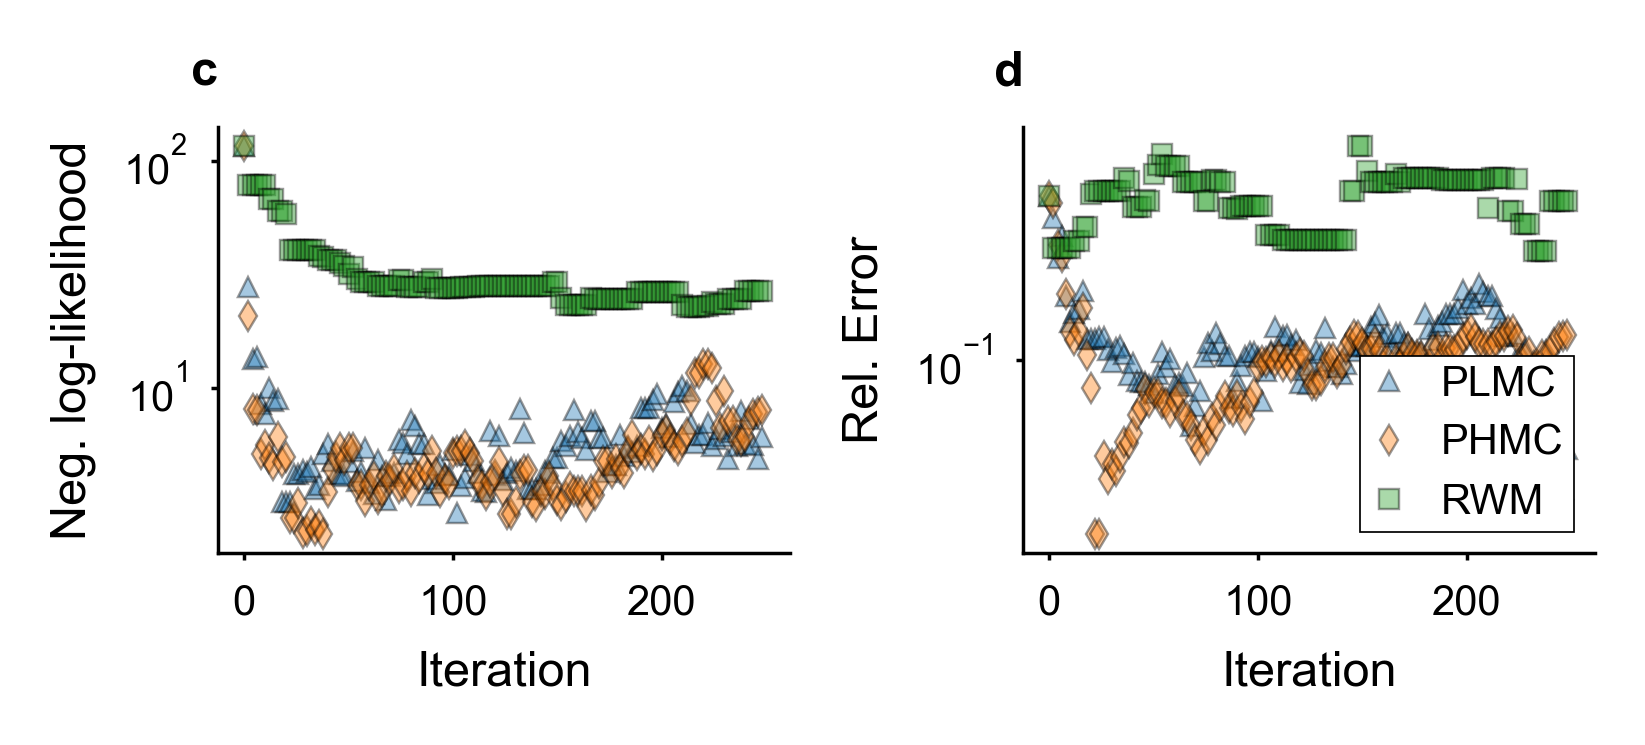

In [13]:
# Plot results
plt.style.use("./icmlstyle.mplstyle")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Neg. log-likelihood")
ax1.semilogy((probs_lang), ls='None', marker="^", label="PLMC", alpha=0.4, markevery=2)
ax1.semilogy((probs_ham), ls='None', marker="d", label="PHMC", alpha=0.4, markevery=2)
ax1.semilogy((probs_rw), ls='None', marker="s", label="RWM", alpha=0.4, markevery=2)

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Rel. Error")
ax2.semilogy(np.abs((samples_lang - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1),  ls='None', marker="^", label="PLMC", alpha=0.4, markevery=2)
ax2.semilogy(np.abs((samples_ham - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), ls='None', marker="d", label="PHMC", alpha=0.4, markevery=2)
ax2.semilogy(np.abs((samples_rw - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), ls='None', marker="s", label="RWM", alpha=0.4, markevery=2)

ax2.legend()
ax1.set_title("c", loc="left", fontweight='bold', ha='right')
ax2.set_title("d", loc="left", fontweight='bold', ha='right')

ax1.minorticks_off()
ax2.minorticks_off()
plt.tight_layout()
plt.savefig("./figures/figure6_sampling_right.pdf")

plt.show()